In [28]:
import sys
sys.path.append('C:/Users/Hubert/repos/radioman-little-helper')


from sklearn.datasets import load_iris

from radler.univariate_analysis import univariate_analysis
from radler.plot import plot_roc_curve

import hashlib
import time
from tqdm import tqdm_notebook
from datetime import datetime
from radler.auto_ml import get_pipeline
from radler.auto_ml import get_param_dist
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import pandas as pd
import os, sys, warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    os.environ['PYTHONWARNINGS'] = 'ignore'

In [29]:
data_iris = load_iris()
X = pd.DataFrame(data_iris['data'])
y = data_iris['target']==1

In [30]:
univariate_analysis(X, y)

,n_neg,n_pos,median_neg,median_pos,direction,cohen_d,AUC,AUC_L,AUC_H,U_stat,U_pval,F_stat,F_pval,H_stat,H_pval,FWER,FDR
0,100,50,5.7,5.90,positive,0.167827,0.5715,0.503000,0.643067,2857.5,1.542841e-01,0.938858,3.341524e-01,2.035062,1.537079e-01,False,False
1,100,50,3.2,2.80,negative,-1.114976,0.7942,0.733988,0.846273,3971.0,3.919743e-09,41.439072,1.595624e-09,34.686763,3.872558e-09,True,True
2,100,50,3.2,4.35,positive,0.434049,0.5089,0.431868,0.586600,2544.5,8.606063e-01,6.279943,1.329302e-02,0.031541,8.590388e-01,False,False
3,100,50,1.0,1.30,positive,0.250173,0.5098,0.430100,0.583200,2549.0,8.459355e-01,2.086218,1.507473e-01,0.038538,8.443674e-01,False,False


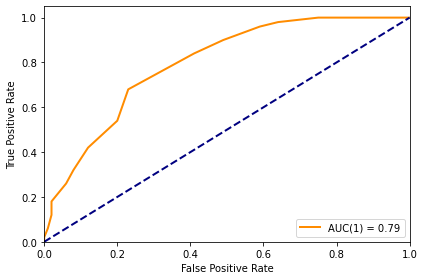

(array([0.  , 0.  , 0.01, 0.02, 0.02, 0.06, 0.08, 0.12, 0.2 , 0.23, 0.41,
        0.49, 0.59, 0.64, 0.75, 0.81, 0.85, 0.88, 0.94, 0.96, 1.  ]),
 array([0.  , 0.02, 0.06, 0.12, 0.18, 0.26, 0.32, 0.42, 0.54, 0.68, 0.84,
        0.9 , 0.96, 0.98, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ]),
 0.7942)

In [31]:
plot_roc_curve(X, 1, data_iris['target']==1)

In [32]:
X = pd.DataFrame(data_iris['data'])
y = data_iris['target']==1

templates = [
    ['decorr', 'standard_scaler', 'power_transformer', 'sfm_lr', 'clf_lr'],
    ['decorr', 'standard_scaler', 'power_transformer', 'sfm_gb', 'clf_lr'],
    ['decorr', 'standard_scaler', 'power_transformer', 'sfm_gb', 'clf_dt'],
    ]

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=313)

df = pd.DataFrame()
for template in tqdm_notebook(templates, desc='template', leave=True):
    pipeline = get_pipeline(template)
    for max_features in tqdm_notebook([2, 4], desc='max features', leave=False):
        param_dist = get_param_dist(pipeline, max_features=max_features)
        for n_iter in tqdm_notebook([10, 30], desc='hyperparameter samples', leave=False):
            model_id = hashlib.md5('{}-{}-{}'.format(template, max_features, n_iter).encode('utf-8')).hexdigest()[:8]
            # train the model
            model = RandomizedSearchCV(pipeline, param_distributions=param_dist, scoring='roc_auc',
                                             n_iter=n_iter, n_jobs=-2, cv=cv, random_state=313, error_score=np.nan, verbose=0)
            start_time = time.time()
            model.fit(X, y)
            auc = pd.DataFrame(model.cv_results_).loc[model.best_index_, 'mean_test_score']
            auc_sd = pd.DataFrame(model.cv_results_).loc[model.best_index_, 'std_test_score']
            # save the results
            exec_time = time.time()-start_time
            current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            df.loc[model_id, 'pipeline'] = '-'.join(template)
            df.loc[model_id, 'max_features'] = max_features
            df.loc[model_id, 'hparam_samples'] = n_iter
            df.loc[model_id, 'cv'] = cv
            df.loc[model_id, 'auc'] = auc
            df.loc[model_id, 'auc_sd'] = auc_sd
            df.loc[model_id, 'exec_time'] = exec_time
            df.loc[model_id, 'time_stamp'] = current_time

In [33]:
df

,pipeline,max_features,hparam_samples,cv,auc,auc_sd,exec_time,time_stamp
2afde,decorr-standard_scaler-power_transformer-sfm_l...,2.0,10.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=...",0.79000,0.080172,0.681879,2020-04-09 19:33:11
5118a,decorr-standard_scaler-power_transformer-sfm_l...,2.0,30.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=...",0.79000,0.080172,1.824644,2020-04-09 19:33:13
b995a,decorr-standard_scaler-power_transformer-sfm_l...,4.0,10.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=...",0.79000,0.080172,0.661787,2020-04-09 19:33:14
6c1c2,decorr-standard_scaler-power_transformer-sfm_l...,4.0,30.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=...",0.82650,0.074500,1.528423,2020-04-09 19:33:16
b9671,decorr-standard_scaler-power_transformer-sfm_g...,2.0,10.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=...",0.77625,0.060604,7.738806,2020-04-09 19:33:23
32bef,decorr-standard_scaler-power_transformer-sfm_g...,2.0,30.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=...",0.79000,0.080172,17.521989,2020-04-09 19:33:41
46895,decorr-standard_scaler-power_transformer-sfm_g...,4.0,10.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=...",0.77625,0.060604,5.142695,2020-04-09 19:33:46
1c98f,decorr-standard_scaler-power_transformer-sfm_g...,4.0,30.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=...",0.79000,0.080172,10.000798,2020-04-09 19:33:56
8d8fe,decorr-standard_scaler-power_transformer-sfm_g...,2.0,10.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=...",0.97500,0.026149,9.048709,2020-04-09 19:34:05
3e52e,decorr-standard_scaler-power_transformer-sfm_g...,2.0,30.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=...",0.97500,0.026149,17.584514,2020-04-09 19:34:23
